In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from time import sleep
import socket,time,requests
from bs4 import BeautifulSoup
import tkinter as tk

import yfinance as yf
import datetime




In [210]:
ticker='GARAN.IS'
start="2021-01-01"
end=str(datetime.date.today() +datetime.timedelta(days=1))
garan=yf.download(ticker,start,end)


[*********************100%***********************]  1 of 1 completed


In [211]:
garan.index=pd.to_datetime(garan.index)
garan

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,10.410000,10.510000,10.320000,10.33,9.201124,131841519
2021-01-05,10.290000,10.410000,10.050000,10.09,8.987352,200649427
2021-01-06,10.200000,10.440000,10.130000,10.40,9.263474,225358010
2021-01-07,10.530000,10.590000,10.390000,10.52,9.370361,162347598
2021-01-08,10.580000,10.810000,10.470000,10.79,9.610855,237594804
...,...,...,...,...,...,...
2023-06-14,28.860001,30.360001,28.700001,29.32,29.320000,109792126
2023-06-15,29.799999,30.760000,29.700001,30.66,30.660000,66227025
2023-06-16,30.879999,31.100000,30.059999,30.08,30.080000,64139443


In [212]:
close=pd.DataFrame(garan["Close"])

close


,Close
Date,
2021-01-04,10.33
2021-01-05,10.09
2021-01-06,10.40
2021-01-07,10.52
2021-01-08,10.79
...,...
2023-06-14,29.32
2023-06-15,30.66
2023-06-16,30.08


In [213]:
rolling_app5=close.rolling(window=5).mean()
rolling_app14=close.rolling(window=14).mean()
rolling_app21=close.rolling(window=21).mean()



In [214]:
MAs=pd.concat([close,rolling_app5,rolling_app14,rolling_app21],axis=1)
MAs.columns=["Close","short","mid","long"]


In [215]:
MAs.dropna(axis=0,inplace=True)
MAs

,Close,short,mid,long
Date,,,,
2021-02-01,9.48,9.362,9.807143,10.017143
2021-02-02,9.69,9.396,9.749286,9.986667
2021-02-03,10.10,9.594,9.735000,9.987143
2021-02-04,9.92,9.700,9.727143,9.964286
2021-02-05,9.76,9.790,9.702143,9.928095
...,...,...,...,...
2023-06-14,29.32,29.740,27.945714,27.195238
2023-06-15,30.66,29.876,28.415714,27.236190
2023-06-16,30.08,29.828,28.808571,27.385714


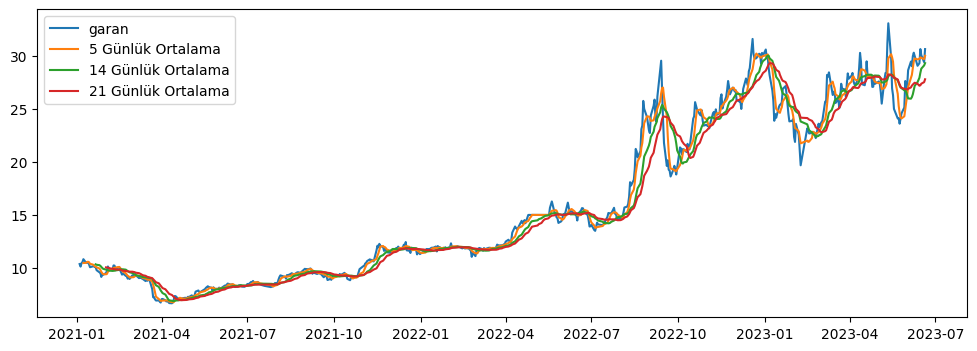

In [216]:
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(close.index,close,label='garan')
ax.plot(rolling_app5.index,rolling_app5,label='5 Günlük Ortalama')
ax.plot(rolling_app14.index,rolling_app14,label='14 Günlük Ortalama')
ax.plot(rolling_app21.index,rolling_app21,label='21 Günlük Ortalama')
ax.legend(loc='upper left')


In [217]:
def buy_sell_MA(data,opt=50):
    buy_sell=[]
    buy_signal=[]
    sell_signal=[]
    flag=42

    up=data[(np.array(data["short"]-data["mid"])>0) & (np.array(data["short"]-data["long"])>0)]
    down=data[(np.array(data["short"]-data["mid"])<0) & (np.array(data["short"]-data["long"])<0)]
    ups=np.percentile(np.array(up["short"]-up["mid"]),opt)
    downs=np.percentile(np.array(down["short"]-down["long"]),opt)


    for i in range(0,len(data)):
       if (data["short"][i]>data["mid"][i]+ups) & (data["short"][i]>data["long"][i]+ups):
            buy_signal.append(np.nan)
            if flag !=1:
                sell_signal.append(data["Close"][i])
                buy_sell.append(data["Close"][i])
                flag=1
            else:
                sell_signal.append(np.nan)
       elif(data["short"][i]<data["mid"][i]+downs)&(data["short"][i]<data["long"][i]+downs):
            sell_signal.append(np.nan)
            if flag!=0:
                buy_signal.append(data["Close"][i])
                buy_sell.append(-data["Close"][i])
                flag=0
            else:
                buy_signal.append(np.nan)
       else:
            buy_sell.append(np.nan)
            sell_signal.append(np.nan)
            buy_signal.append(np.nan)

    operations=np.array(buy_sell)
    operations=operations[~np.isnan(operations)]

    neg=0
    pos=0

    for i in range(len(operations)):
        if operations[i]<0:
            neg=i
            break
    for i in range(1,len(operations)):
        if operations[-i]>0:
            pos=i-1
            break
    
    PL=np.sum(operations)
    

    
    
    return (buy_signal,sell_signal,PL)





In [218]:
MAs["Buy"]=buy_sell_MA(MAs)[0]
MAs["Sell"]=buy_sell_MA(MAs)[1]

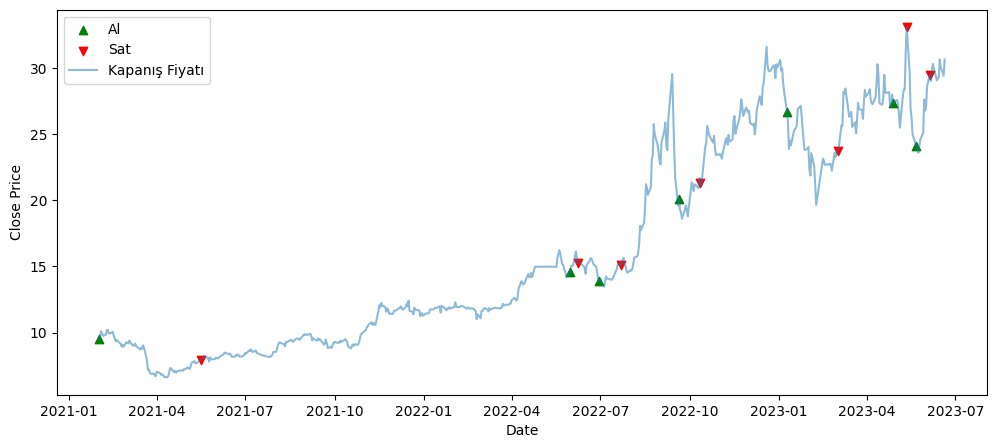

In [219]:
plt.figure(figsize=(12,5))
plt.scatter(MAs.index,MAs["Buy"],color="green",label='Al',marker='^',alpha=1)
plt.scatter(MAs.index,MAs["Sell"],color="red",label='Sat',marker='v',alpha=1)
plt.plot(MAs["Close"],label='Kapanış Fiyatı',alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc='upper left')
plt.show()

## Optimizing percentile variable to find best performance

In [220]:
def kar(percentile):
    MAs["Buy"]=buy_sell_MA(MAs,percentile)[0]
    MAs["Sell"]=buy_sell_MA(MAs,percentile)[1]
    al=MAs["Buy"]
    al=al.dropna(axis=0)
    sat=MAs["Sell"]
    sat=sat.dropna(axis=0)
    sat_val=sat.values
    al_val=al.values
    res=[]
    if len(al_val)==len(sat_val):
        for i in range(len(al_val)):
           res.append(sat_val[i]/al_val[i])
    elif len(al_val)>len(sat_val):
        al_val=np.delete(al_val,-1)
        for j in range(len(sat_val)):
           res.append(sat_val[j]/al_val[j])
    elif (len(sat_val)>len(al_val)):
        sat_val=np.delete(sat_val,0)
        for k in range(len(al_val)):
            res.append(sat_val[k]/al_val[k])
    
        

    
       

    

    df=pd.DataFrame()
    df["Kar"]=res

    return np.prod(df["Kar"])

In [221]:
MAs["Buy"]=buy_sell_MA(MAs,50)[0]
MAs["Sell"]=buy_sell_MA(MAs,50)[1]
al=MAs["Buy"]
al=al.dropna(axis=0)
sat=MAs["Sell"]
sat=sat.dropna(axis=0)
sat_val=sat.values
al_val=al.values

In [222]:
percentile=range(1,100)



In [223]:
kardf=pd.DataFrame()
kardf["Percentile"]=percentile

In [224]:

for i in range(len(percentile)):
  kardf.loc[i,1]=kar(percentile[i])

In [225]:
kardf.columns=["Percentile","Performance"]
kardf=kardf.sort_values(by="Performance",ascending=False)
kardf

,Percentile,Performance
87,88,4.827566
86,87,4.827566
91,92,4.709625
85,86,4.682476
88,89,4.574281
...,...,...
4,5,1.111691
3,4,1.111691
6,7,1.106493
5,6,1.106493


In [226]:
MAs["Buy"]=buy_sell_MA(MAs,kardf["Percentile"].values[0])[0]
MAs["Sell"]=buy_sell_MA(MAs,kardf["Percentile"].values[0])[1]

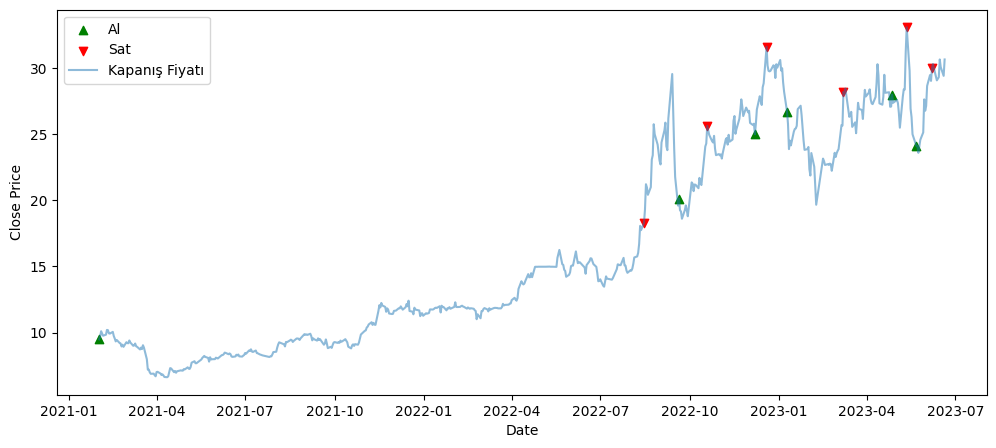

In [227]:
plt.figure(figsize=(12,5))
plt.scatter(MAs.index,MAs["Buy"],color="green",label='Al',marker='^',alpha=1)
plt.scatter(MAs.index,MAs["Sell"],color="red",label='Sat',marker='v',alpha=1)
plt.plot(MAs["Close"],label='Kapanış Fiyatı',alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc='upper left')
plt.show()

In [228]:
al=MAs["Buy"]
al=al.dropna(axis=0)
al

Date
2021-02-01     9.480000
2022-09-20    20.139999
2022-12-07    25.000000
2023-01-09    26.719999
2023-04-27    28.000000
2023-05-22    24.100000
Name: Buy, dtype: float64

In [229]:
sat=MAs["Sell"]
sat=sat.dropna(axis=0)
sat


Date
2022-08-15    18.299999
2022-10-19    25.639999
2022-12-19    31.620001
2023-03-08    28.219999
2023-05-12    33.099998
2023-06-07    29.980000
Name: Sell, dtype: float64

In [230]:
sat_val=sat.values
al_val=al.values


In [231]:
res=[]

for i in range(len(al_val)):
    res.append((sat_val[i]/al_val[i]))

In [232]:
df=pd.DataFrame()
df["Kar"]=res
df

,Kar
0,1.930380
1,1.273088
2,1.264800
3,1.056138
4,1.182143
5,1.243983


In [233]:
res0=[100]
for i in range(len(df.index)):
    res0.append(res0[i]*df["Kar"].loc[i])

df["Eldeki Para"]=res0[1:]
df


,Kar,Eldeki Para
0,1.930380,193.037976
1,1.273088,245.754406
2,1.264800,310.830181
3,1.056138,328.279480
4,1.182143,388.073225
5,1.243983,482.756636


In [234]:
karlilik=df["Eldeki Para"].iloc[-1]/100
karlilik=(karlilik-1)*100
print("Karlılık oranı %",karlilik)

Karlılık oranı % 382.75663587153383
